### Efficient Model Prototypes
1. Shrink Residual Dense Block (SRDB)
2. Group Residual Dense Block (GRDB)
3. Contextual Residual Dense Block (CRDB)

In [2]:
import torch 
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import h5py
import numpy as np
from torch.utils.data import IterableDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import timeit
from itertools import islice
import sys
import os
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn
from tqdm import tqdm
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import math
import tensorflow as tf
from pytorch_msssim import ssim
import PIL.Image as pil_image
import io
import random
from torchvision import transforms
import cv2
import torch.nn.functional as F 
from torch.autograd import Variable

### Residual Dense Network

In [3]:
class sub_pixel(nn.Module):
    def __init__(self, scale, act = False):
        super(sub_pixel, self).__init__()
        modules = []
        modules.append(nn.PixelShuffle(scale))
        self.body = nn.Sequential(*modules)
    def forward(self, x):
        x = self.body(x)
        return x
        
class make_dense(nn.Module):
    def __init__(self, nChannels, growthRate, kernel_size=3):
        super(make_dense, self).__init__()
        self.conv = nn.Conv2d(nChannels, growthRate, kernel_size=kernel_size, padding=(kernel_size-1)//2, bias=False)
    def forward(self, x):
        out = F.relu(self.conv(x))
        out = torch.cat((x, out), 1)
        return out

# Residual dense block (RDB) architecture
class RDB(nn.Module):
    def __init__(self, nChannels, nDenselayer, growthRate):
        super(RDB, self).__init__()
        nChannels_ = nChannels
        modules = []
        for i in range(nDenselayer):    
            modules.append(make_dense(nChannels_, growthRate))
            nChannels_ += growthRate 
        self.dense_layers = nn.Sequential(*modules)    
        self.conv_1x1 = nn.Conv2d(nChannels_, nChannels, kernel_size=1, padding=0, bias=False)
    def forward(self, x):
        out = self.dense_layers(x)
        out = self.conv_1x1(out)
        out = out + x
        return out

In [26]:
# Residual Dense Network
class RDN(nn.Module):
    def __init__(self, num_channel, num_denselayer, num_feat, in_scale, growth_rate):
        super(RDN, self).__init__()
        nChannel = num_channel
        nDenselayer = num_denselayer
        nFeat = num_feat
        scale = in_scale
        growthRate = growth_rate

        # F-1
        self.conv1 = nn.Conv2d(nChannel, nFeat, kernel_size=3, padding=1, bias=True)
        # F0
        self.conv2 = nn.Conv2d(nFeat, nFeat, kernel_size=3, padding=1, bias=True)
        # RDBs 3 
        self.RDB1 = RDB(nFeat, nDenselayer, growthRate)
        self.RDB2 = RDB(nFeat, nDenselayer, growthRate)
        self.RDB3 = RDB(nFeat, nDenselayer, growthRate)
        # global feature fusion (GFF)
        self.GFF_1x1 = nn.Conv2d(nFeat*3, nFeat, kernel_size=1, padding=0, bias=True)
        self.GFF_3x3 = nn.Conv2d(nFeat, nFeat, kernel_size=3, padding=1, bias=True)
        # Upsampler
        self.conv_up = nn.Conv2d(nFeat, nFeat*scale*scale, kernel_size=3, padding=1, bias=True)
        self.upsample = sub_pixel(scale)
        # conv 
        self.conv3 = nn.Conv2d(nFeat, nChannel, kernel_size=3, padding=1, bias=True)
        
    def _initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
    
    def forward(self, x):

        F_  = self.conv1(x)
        F_0 = self.conv2(F_)
        F_1 = self.RDB1(F_0)
        F_2 = self.RDB2(F_1)
        F_3 = self.RDB3(F_2)     
        FF = torch.cat((F_1, F_2, F_3), 1)
        FdLF = self.GFF_1x1(FF)         
        FGF = self.GFF_3x3(FdLF)
        FDF = FGF + F_
        us = self.conv_up(FDF)
        us = self.upsample(us)

        output = self.conv3(us)


        return output

### Model Train

In [18]:
class HDF5_Datasetv5(Dataset):
    
    def __init__(self, file, batch_size, color_mode='RGB', mode='Training'):
        
        self.file = h5py.File(file,'r')
        
        self.labels = self.file[color_mode + '/' + mode + '/Labels'] 
        
        self.inputs = self.file[color_mode + '/' + mode + '/Inputs']
        
        self.total_images = self.file[color_mode + '/' + mode].attrs[mode.lower() + '_images']
        
        self.batch_size = batch_size
        
        self.index_list = np.arange(self.__len__())
        
    def shuffle_index(self):
        
        np.random.shuffle(self.index_list)
            
    def batch_indexer(self,index):
        
        shuffled_index = self.index_list[index]
        
#         print(shuffled_index*self.batch_size, (shuffled_index+1)*self.batch_size)
        
        return shuffled_index*self.batch_size, (shuffled_index+1)*self.batch_size
    
    def __getitem__(self,idx):
        
        start_index, end_index = self.batch_indexer(idx)
            
        return self.inputs[start_index:end_index,:,:,:], self.labels[start_index:end_index,:,:,:]
    
    def done(self):
        
        self.file.close()
        
    def __len__(self):
        
        return self.total_images//self.batch_size


In [20]:
class Val_Image_Dataset(Dataset):
    
    """Batch size of only 1 is possible since we are extracting images of different sizes."""
    
    def __init__(self, orig_img_dir, jpeg_img_dir):
        
        self.orig_img_dir = orig_img_dir
        self.jpeg_img_dir = jpeg_img_dir
        
        self.orig_imgs = os.listdir(orig_img_dir)
        self.jpeg_imgs = os.listdir(jpeg_img_dir)
        
        #After Google Colab size mismatch error
        self.orig_imgs.sort()
        self.jpeg_imgs.sort()
        
        if len(os.listdir(orig_img_dir)) != len(os.listdir(jpeg_img_dir)):
            raise EOFError('No. of images in both directories do not correspond.')
        
    def __getitem__(self,idx):
        
        orig_img = pil_image.open(self.orig_img_dir+'/'+self.orig_imgs[idx])
        jpeg_img = pil_image.open(self.jpeg_img_dir+'/'+self.jpeg_imgs[idx])
        #Current addition
        orig_np = np.asarray(orig_img).astype(np.float32)
        jpeg_np = np.asarray(jpeg_img).astype(np.float32)
        input = np.expand_dims(jpeg_np,axis=0)/255.0
        label = np.expand_dims(orig_np,axis=0)/255.0
        return input,label
        
        
    def __len__(self):
        
        return len(self.orig_imgs)


In [21]:
class model_mainv2:
    
    def __init__(self, color_mode, model, jpeg_quality):
        
        self.jpeg_quality = jpeg_quality
        self.color_mode   = color_mode
        if type(model) == str:
            self.model = str_to_class(model)()
        else:
            self.model = model
        
    def train(self, train_file, val_dir, output_dir, train_batch_size, loss_fn = 'MSELoss', 
              val_img = 'BSD500_val', optimizer = None, lr = None, weight_decay = None, 
              num_epochs = 8, plot = True, save_weights =  False, save_performance = False, 
              ssim_psnr = True, debugging = False, model = None ):
        
        if torch.cuda.is_available:
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")

        self.model.to(device)
        
        criterion = str_to_class(loss_fn, torch.nn)()
        
        if optimizer is None:
            optimizer = str_to_class(convert_params(self.model.network_params)[-1][-5], torch.optim)
        else:
            optimizer = str_to_class(optimizer, torch.optim)
        
        if lr is None:
            lr = convert_params(self.model.network_params)[-1][-4]

        if weight_decay is None: 
            weight_decay = convert_params(self.model.network_params)[-1][-3]
        
        
        optimizer = optimizer(self.model.parameters(),lr = lr, weight_decay=weight_decay)
        
        #TODO: If using EvoARCNN
#         optimizer = optimizer([{'params': self.model.conv_blocks.parameters()},
#                                {'params': self.model.last.parameters(), 'lr': lr * 0.1},], lr=lr, weight_decay = weight_decay)
    
        
#         #TODO: If using ARCNN or FastARCNN
#         optimizer = optimizer([{'params': self.model.base.parameters()},
#                                {'params': self.model.last.parameters(), 'lr': lr * 0.1},], lr=lr)

        train_dataset = HDF5_Datasetv5(train_file, train_batch_size, self.color_mode, 'Training')
    
        validation_dataset = Val_Image_Dataset(val_dir + '/' + val_img + '_Y', 
                                               val_dir + '/' + val_img + '_Y_JPEG' + str(self.jpeg_quality))
        
#         validation_dataset = HDF5_Datasetv5(input_file, batch_size, self.color_mode, 'Validation')
        
#         validloader = DataLoader(dataset=validation_dataset, batch_size=None, pin_memory=True)
    
        trainloader = DataLoader(dataset=train_dataset, batch_size=None, pin_memory=True)
        
        
        ##Important : Only batch size of 1 is possible since we are using images of apparently different sizes.
        validloader = DataLoader(dataset=validation_dataset, batch_size=1, pin_memory=True)
        
        self.training_loss = Losstracker()
        
        self.validation_loss = Losstracker()
        
        self.batch_quality = Batch_quality(ssim_psnr)
        
        for epoch in range(num_epochs):
            
            with tqdm(total=(len(train_dataset)*train_batch_size )) as _tqdm:
                
                _tqdm.set_description('epoch: {}/{}'.format(epoch + 1, num_epochs))
                
                torch.set_grad_enabled(True)
                self.model.train()                

                for batch in trainloader:

                    optimizer.zero_grad()
            
                    inputs, labels = batch
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = self.model(inputs)
                    loss = criterion(outputs,labels)
                    self.training_loss.update(loss.item())
                    
                    loss.backward()
                    optimizer.step()
                    
                    _tqdm.set_postfix(Training_loss = '{:.6f}'.format(self.training_loss.avg))
                    
                    _tqdm.update(len(inputs))
                
            with tqdm(total=(len(validation_dataset) )) as _tqdm2:
                
                _tqdm2.set_description('epoch: {}/{}'.format(epoch + 1, num_epochs))
                
                torch.set_grad_enabled(False)
                self.model.eval()
                
                if debugging == True:
                    t=0
                
                for batch in validloader:
            
                    inputs, labels = batch
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = self.model(inputs)
                    loss = criterion(outputs,labels)
                    self.validation_loss.update(loss.item())
                    
                    if debugging == True:
                        t +=1 
                        if t%40 == 0:
                            a = outputs[0].mul(255.0).clamp(0.0,255.0).squeeze(0).permute(1,2,0).byte().cpu().numpy()
                            b = outputs[10].mul(255.0).clamp(0.0,255.0).squeeze(0).permute(1,2,0).byte().cpu().numpy()
                            a = pil_image.fromarray(a)
                            b = pil_image.fromarray(b)
                            a.save(os.path.join(output_dir, '{}_{}_0.png'.format(epoch, t)))
                            b.save(os.path.join(output_dir, '{}_{}_10.png'.format(epoch, t)))
                        
                    
                    if ssim_psnr == True:
                        
                        self.batch_quality.update(outputs, labels)
                        _tqdm2.set_postfix(Validation_loss = '{:.4f}'.format(self.validation_loss.avg), 
                                           PSNR = '{:.4f}'.format(self.batch_quality.psnr_avg), 
                                           SSIM = '{:.4f}'.format(self.batch_quality.ssim_avg))
                        _tqdm2.update(len(inputs))
                        
                    else:
                        
                        _tqdm2.set_postfix(Validation_loss = '{:.6f}'.format(self.validation_loss.avg))
                        _tqdm2.update(len(inputs))
                    
            self.training_loss.reset()
            self.validation_loss.reset()
            self.batch_quality.reset()
            train_dataset.shuffle_index()
            
            if save_weights == True:
                
                if model is None:
                    
                    torch.save(self.model.state_dict(), os.path.join(output_dir, '{}_epoch_{}_{}_{}.pth'.
                                                                 format(str(self.model).split('(')[0], epoch,self.color_mode,self.jpeg_quality )))
                else:
                    
                    torch.save(self.model.state_dict(), os.path.join(output_dir, '{}_epoch_{}_{}_{}_{}.pth'.
                                                                 format(str(self.model).split('(')[0], epoch,self.color_mode,self.jpeg_quality,model )))
                    
                
                
            timeit.time.sleep(1)
            
        train_dataset.done()
        
        if save_performance == True:
            
            file = open(os.path.join(output_dir + '/' + model + '.txt'),'w+')
            file.write('Model_Chromosome = ' + repr(self.model.network_params)+'\n')
            file.write('Model = ' + repr(convert_params(self.model.network_params)) + '\n' )
            file.write('Training_Loss = ' + repr(self.training_loss.tracker) + '\n')
            file.write('Validation_Loss = ' + repr(self.validation_loss.tracker) + '\n')
            file.write('SSIM = ' + repr(self.batch_quality.ssim) + '\n')
            file.write('PSNR = ' + repr(self.batch_quality.psnr))
            file.close()

        if plot == True:
            
            self.plotting(num_epochs, self.training_loss, self.validation_loss, self.batch_quality, ssim_psnr)
            
    def plotting(self, num_epochs, training_loss, validation_loss, batch_quality, ssim_psnr):
        
        epochs = [i+1 for i in range(num_epochs)]
        plots = 2
        
        fig = plt.figure(figsize=(18,5))
        
        if ssim_psnr ==True:
            
            plots = 4
            plt.subplot(1,plots,3)
            plt.plot(epochs,batch_quality.psnr)
            plt.title("PSNR")
            plt.xlabel("Epochs")
            
            plt.subplot(1,plots,4)
            plt.plot(epochs,batch_quality.ssim)
            plt.title("SSIM")
            plt.xlabel("Epochs")
            
        plt.subplot(1,plots,1)
        plt.plot(epochs,training_loss.tracker)
        plt.title("Training Loss")
        plt.xlabel("Epochs")

        plt.subplot(1,plots,2)
        plt.plot(epochs,validation_loss.tracker)
        plt.title("Validation Loss")
        plt.xlabel("Epochs")
        
        plt.show()    
        
    def inference(self, input_image, output_dir, input_weights=None, save_output=True, jpeg_quality=10):

        if input_weights != None:
            state_dict = self.model.state_dict()
            for n, p in torch.load(input_weights, map_location=lambda storage, loc: storage).items():
                if n in state_dict.keys():
                    state_dict[n].copy_(p)
                else:
                    raise KeyError(n)
        
        device = torch.device("cuda")
        
        self.model.to(device)
        self.model.eval()

        filename = os.path.basename(input_image).split('.')[0]
        
        if self.color_mode == 'RGB':
            input_orig = pil_image.open(input_image)
            
        if self.color_mode == 'YCbCr':
            input_orig = pil_image.open(input_image).convert(self.color_mode).split()[0]
        
        buffer = io.BytesIO()
        input_orig.save(buffer, format='jpeg', quality=jpeg_quality)
        input_jpeg = pil_image.open(buffer)
        
        input_temp = transforms.ToTensor()(input_jpeg).unsqueeze(0).to(device)
            
        with torch.no_grad():
            pred = self.model(input_temp)
            
        if save_output == True:
            input_orig.save(os.path.join(output_dir, '{}_original.png'.format(filename)))
            input_jpeg.save(os.path.join(output_dir, '{}_jpeg_q{}.png'.format(filename, jpeg_quality)))
            
        if self.color_mode == 'RGB':
            
            pred = pred.mul_(255.0).clamp_(0.0, 255.0).squeeze(0).permute(1, 2, 0).byte().cpu().numpy()
            output = pil_image.fromarray(pred, mode=self.color_mode)
            
            if save_output == True:
            
                output.save(os.path.join(output_dir, '{}_{}.png'.format(filename, str(self.model).split('(')[0])))
    
            print("JPEG- PSNR : {}, SSIM : {}".format(peak_signal_noise_ratio(np.asarray(input_orig),np.asarray(input_jpeg)),
                                               structural_similarity(np.asarray(input_orig),np.asarray(input_jpeg),multichannel=True)))
    
          
            print("ARCNN- PSNR : {}, SSIM : {}".format(peak_signal_noise_ratio(np.asarray(input_orig),np.asarray(output)),
                                               structural_similarity(np.asarray(input_orig),np.asarray(output),multichannel=True)))
        
            fig = plt.figure(figsize=(20,20))
            ax1 = plt.subplot(1,3,1)
            plt.imshow(input_orig)
            ax2 = plt.subplot(1,3,2)
            plt.imshow(input_jpeg)
            ax3 = plt.subplot(1,3,3)
            plt.imshow(output)
            plt.show()

In [ ]:
# num_channel, num_denselayer, num_feat, in_scale, growth_rate
# parser.add_argument('--nDenselayer', type=int, default=6, help='nDenselayer of RDB')
# parser.add_argument('--growthRate', type=int, default=32, help='growthRate of dense net')
# parser.add_argument('--nBlock', type=int, default=16, help='number of RDB block')
# parser.add_argument('--nFeat', type=int, default=64,  help='number of feature maps')
# parser.add_argument('--nChannel', type=int, default=3, help='number of color channels to use')
# parser.add_argument('--patchSize', type=int, default=96,  help='patch size')

In [8]:
rdn = RDN(1, 4, 64, 1, 32)

In [31]:
evo_mod = model_mainv2('YCbCr',RDN(1, 4, 64, 1, 32),10)

epoch: 8/8: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s, PSNR=27.9088, SSIM=0.7609, Validation_loss=0.0019]


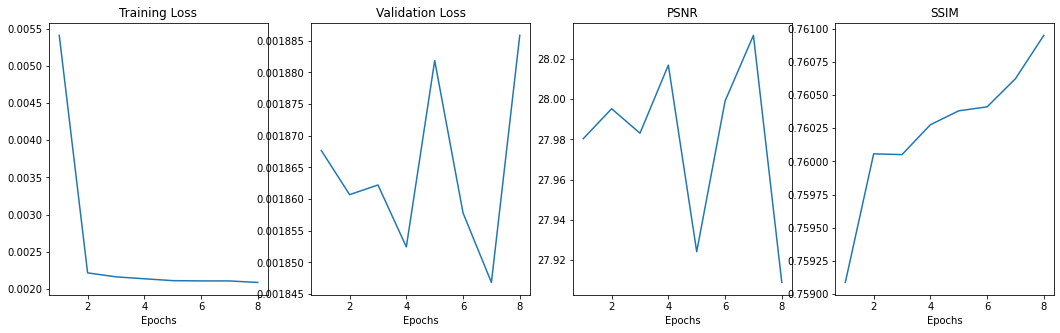

In [32]:
evo_mod.train(train_file='../Image_Compression/Research_Data/HDF5_Files/Images_24_100000_10_Y.hdf5', 
                val_dir = 'Training_Val',
                output_dir='/content/drive/My Drive/ARCNN_Phase2/30Pop-6Gen/Model_Weights',
                train_batch_size=100,loss_fn='MSELoss',optimizer='Adam',lr=0.0001,weight_decay=0.0005,
              num_epochs = 8,save_weights=False,save_performance=False, model='Model2')

In [11]:
def str_to_class(classname, module = sys.modules[__name__]):
    
        return getattr(module, classname)

class Batch_quality(object):
    
    def __init__(self, activate):
        self.ssim = []
        self.psnr = []
        self.ssim_avg = 0
        self.ssim_sum = 0
        self.psnr_avg = 0
        self.psnr_sum = 0
        self.count = 0
        self.activate = activate
    
    def reset(self):
        if self.activate == True:
            self.ssim.append(self.ssim_avg)
            self.psnr.append(self.psnr_avg)
        self.ssim_avg = 0
        self.psnr_avg = 0
        self.ssim_sum = 0
        self.psnr_sum = 0
        self.count = 0
    
    def update(self, outputs, labels):
        
        output_tf = tf.convert_to_tensor(np.transpose(outputs.cpu().numpy(),axes=[0,2,3,1]))
        label_tf = tf.convert_to_tensor(np.transpose(labels.cpu().numpy(),axes=[0,2,3,1]))
        self.psnr_sum += np.mean(tf.image.psnr(output_tf, label_tf, max_val=1.0).numpy())
#         self.ssim_sum += ssim( outputs.cpu(), labels.cpu(), data_range=1, size_average=True).item()
        self.ssim_sum += ssim( outputs.cpu(), labels.cpu(), data_range=1, size_average=True).item()
        self.count +=1
        self.ssim_avg = self.ssim_sum/self.count
        self.psnr_avg = self.psnr_sum/self.count
        

class Losstracker(object):
    def __init__(self):
        self.tracker = []
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.tracker.append(self.avg)
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val):
        self.sum += val 
        self.count += 1
        self.avg = self.sum / self.count

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### 1. SRDB

In [ ]:
#Padding size = (Filter size - 1) // 2 for same size
class SRDB(nn.Module):
    
    def __init__(self, input_channels):
        
        super(SRDB, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = input_channels, )

In [ ]:
class ConvBlock(nn.Module):

    def __init__(self,  params, input_channels):
        
        super(ConvBlock, self).__init__()
        
        num_conv_layer, num_filters, filter_size, dropout_prob, activation_fn, batch_norm, short_connection = self.convert_cnn_block_parameters(params)               
        
        self.short_connection = short_connection
        
        self.channels = input_channels
        
        self.cnn_block = nn.Sequential()
        
        #TODO:This for the last output after addition of the residual connection, considering changing it to only LeakyRelU
        if short_connection == 1:
            
            self.activation_fn = nn.__getattribute__(activation_fn)()
        
        self.conv_residual = None
        
        #Caculated such that the output size after convolution operation is equal to the input size
        padding_size = (filter_size - 1) // 2       
        
        #TODO:Stride for convolutional layers is 1
        for layers in range(1,num_conv_layer+1):
            
            self.cnn_block.add_module("Conv_layer" + str(layers),nn.Conv2d(in_channels=self.channels,out_channels=num_filters,
                                                                      kernel_size=filter_size,stride=1,padding=padding_size))
            self.channels = num_filters
            
            if batch_norm == 1:
        
                self.cnn_block.add_module("Batch_Norm"+str(layers), nn.BatchNorm2d(self.channels))
            
            self.cnn_block.add_module("Activation" + str(layers),nn.__getattribute__(activation_fn)())
            
            self.cnn_block.add_module("Dropout" + str(layers),nn.Dropout2d(p=dropout_prob,))
        
        #TODO:Residual kernel is 1x1
        if self.channels != input_channels and short_connection==1:
            
            self.conv_residual = nn.Conv2d(in_channels=input_channels, out_channels=self.channels, kernel_size=1, stride=1)
        
    def convert_cnn_block_parameters(self, param_list):
    
        """Converts the conv block parameters not the optimizer and learning rate from the chromosome"""

        #Parameters = [Block act, No of conv, No. of filters, Filter size, Dropout, Activation fn., Batch Norm, Short Connection]
        num_of_filters     = [8,16,32,64]
        filter_sizes       = [1,3,5,7,9]
        activation_funs    = ['PReLU','LeakyReLU','SELU','Softplus','GELU']

        conv_layers      =  math.floor(param_list[1])
        num_filters      =  num_of_filters[math.floor(param_list[2])]
        filter_dim       =  filter_sizes[math.floor(param_list[3])]
        dropout_prob     =  param_list[4]
        activation       =  activation_funs[math.floor(param_list[5])]
        batch_norm       =  round(param_list[6])
        short_connection =  round(param_list[7])

        return conv_layers, num_filters, filter_dim, dropout_prob, activation, batch_norm, short_connection
    
    def forward(self, x):
        
        if self.short_connection == 1:
            
            if self.conv_residual is not None:
                
                residual = self.conv_residual(x)
                
            else:
            
                residual = x
                
            out = self.cnn_block(x) 
            result = out + residual
            result = self.activation_fn(result)
            return result
                
        else:
            
            return self.cnn_block(x)
       

In [ ]:
class Vanilla_EvoARCNNv5(nn.Module):
    """For Convblock ---> Conv + BatchNorm + Relu + ..... + Residual at end ----> Whole passed through a """
    
    def __init__(self, network_params, input_channels, block, cnn_genes = 8, optim_genes=5):
        
        super().__init__()
        
        self.conv_blocks    = nn.Sequential()
        
        self.network_params = network_params
        
        self.current_channels = input_channels     #------>Instance variable changes with each conv block
        
        for block_idx in range(0,len(network_params)-optim_genes,cnn_genes):  #----->Accesses 1st indice of each conv block (Excluding last 2 parameters) 
            
            if round(network_params[block_idx])==1:
                
                self.conv_blocks.add_module("Conv_Block_" + str(block_idx//cnn_genes + 1),
                                            self.create_conv_block(network_params[block_idx:block_idx+cnn_genes], block))
                
        self.last = nn.Conv2d(self.current_channels, input_channels, kernel_size=5, padding=2)  
         
        self.long_connection = round(network_params[-2])
        
        if self.long_connection == 1:      #-------->Optim attributes : [Optimizer,lr,weight_decay,long_conn,final_act_fn]
            
            self.create_activation_fn(network_params[-1])
            
        self._initialize_weights()
    
    def create_activation_fn(self, activation_param):
        
        activation_funs = ['PReLU','LeakyReLU','Softplus','GELU' ]
        activation_fn = activation_funs[math.floor(activation_param)]
        
        self.last_activation = nn.__getattribute__(activation_fn)() 
        
    def create_conv_block(self, params, block):
        
        #Parameters = [Block act, No of conv, No. of filters, Filter size, Dropout, Activation fn., Batch norm, Short Connection]
        #Number of filters and filter size is same for both convolutional layers if present
        
        layers = []
        
        conv_block = block(params, self.current_channels)
        
        self.current_channels = conv_block.channels 
        
        layers.append(conv_block)
        
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
    
    def forward(self,x):
        
        if self.long_connection == 1:
        
            residual = x

            x = self.conv_blocks(x)
        
            x = self.last(x)
            
            x = x + residual
        
            x = self.last_activation(x)
        
        else:
            
            x = self.conv_blocks(x)
            
            x = self.last(x)
        
        return x